# Introduction into handling geographical data

[John Snow](https://en.wikipedia.org/wiki/John_Snow) was an English physician, who was first to trace the source of a cholera outbreak in London's Soho district in 1854 using data visualization. In the following exercises, we are going to reconstruct the map of Snow with modern tools and explore some ideas of geographic data analysis.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/Snow-cholera-map-1.jpg" width="400px"></img>

Though there is a whole [R library](https://vincentarelbundock.github.io/Rdatasets/doc/HistData/Snow.pumps.html) dedicated to this dataset, we would like R users to also build the solutions (e.g. Voronoi cells) from scratch.

Further reading:
* https://en.wikipedia.org/wiki/1854_Broad_Street_cholera_outbreak
* https://www1.udel.edu/johnmack/frec682/cholera/cholera2.html
* https://www.theguardian.com/news/datablog/interactive/2013/mar/15/cholera-map-john-snow-recreated

The shapefile that will be used in these exercises are located at http://donboyes.com/2011/10/14/john-snow-and-serendipity/, but they are already downloaded into the shapes directory.

In [1]:
import json
import scipy
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import folium
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from IPython.display import display

#### Matplotlib and Seaborn parameter tuning

In [2]:
# Control chars for bold text in print() statements
b_on = '\033[1m'
b_off = '\033[0m'

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.1',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

## Exercise 1

Load the death and the pump dataset into a tabular format! Have a look at the dataset's structure! The pump dataset contains the locations of wells, that were used to obtain water for drinking, cooking etc.

*The format of the files is called [shapefile](https://en.wikipedia.org/wiki/Shapefile), which is a format that is easily readable by the most common GIS (Geographic Information System) softwares. Shapefiles consist of many files, some of which store the geographic information, some the coordinate system description, some the additional attributes of the geographical objects. [geopandas](http://geopandas.org/) is able to read shapefiles natively into its base class GeoDataFrame, which has a similar API to that of `pandas` `DataFrames`. This is convenient, because we can use all of our previous knowledge of `pandas`.*

*It is sometimes worth to have a look at a shapefile's content quickly. For Linux, [QGIS](https://www.qgis.org/en/site/about/index.html) is a powerful free GIS system, try it at home!*

In [3]:
# Read random shapefiles
deaths = gpd.read_file('/home/workdir/followingjohnsnow/shapes/deaths_gcs.shp')
pumps = gpd.read_file('/home/workdir/followingjohnsnow/shapes/pumps_gcs.shp')

**The original datafiles**

In [4]:
display(deaths.head())
display(pumps.head())

,OBJECTID,X,Y,geometry
0,1,13.588010,11.095600,POINT (-0.1358510124179086 51.51294954729676)
1,2,9.878124,12.559180,POINT (-0.138770102002734 51.51371230751689)
2,3,14.653980,10.180440,POINT (-0.1350160883265595 51.51248811121285)
3,4,15.220570,9.993003,POINT (-0.1345699931742053 51.51238929251129)
4,5,13.162650,12.963190,POINT (-0.1361725598760318 51.51386954122671)


,OBJECTID,X,Y,geometry
0,1,8.651201,17.891600,POINT (-0.1396208554870189 51.51630294134797)
1,2,10.984780,18.517851,POINT (-0.1377342856072615 51.51658205873352)
2,3,13.378190,17.394541,POINT (-0.1358459998004841 51.51601929553199)
3,4,14.879830,17.809919,POINT (-0.1346316790272766 51.5162048651341)
4,5,8.694768,14.905470,POINT (-0.1396648470900002 51.51486655853756)


## Exercise 2

Extract the latitudes and the longitudes for each row in both datasets as additional columns!

*In a `GeoDataFrame`, the `geometry` column contains geometry objects from the [`shapely`](https://toblerity.org/shapely/index.html) library. These objects have coordinate attributes, that is where latitude and longitude values are stored.*

The 'X' and 'Y' columns are coordinates in an arbitrary coordinate system and usually not part of a *shp* file. 

Project your points into a coordinate system where you can measure real distances (using e.g. `pyproj`), then create a meaningul visualization of the data!

*It is crucial to use the appropriate coordinate system for your purposes. For this exercise, the spherical coordinate system of lon, lat values is not convenient, since we cannot calculate distances in meters as easily as we would in a Cartesian coordinate system. Because of the Earth's shape, most projections distort distances at certain latitudes and longitudes.*

*In GIS, different coordinate systems are called CRS (Coordinate Reference System), and have patented codes that define the origin, the projection etc. The usual lon, lat pairs are called the WGS84 system (you will need to find its epsg code first). A good choice for a Cartesian system is for example the Pseudo-Mercator projection. The `pyproj` library is especially lightweight to use in Python.*

### Append additional Lat-Long columns to the datasets

In [5]:
# Add additional Lat-Long columns to deaths and pumps GeoDFs
# Use the `geometry` column to get coordinate values
pumps['geometry']

0     POINT (-0.1396208554870189 51.51630294134797)
1     POINT (-0.1377342856072615 51.51658205873352)
2     POINT (-0.1358459998004841 51.51601929553199)
3      POINT (-0.1346316790272766 51.5162048651341)
4     POINT (-0.1396648470900002 51.51486655853756)
5     POINT (-0.1395857604974621 51.51383010781676)
6     POINT (-0.1366423080892936 51.51330152898869)
7     POINT (-0.1382867880533047 51.51125233875185)
8       POINT (-0.1359805300653406 51.511480032129)
9      POINT (-0.133611652586659 51.51207478005433)
10    POINT (-0.1316118626847843 51.51228494732037)
11    POINT (-0.1340671776302035 51.51005639428306)
12    POINT (-0.1396797647617649 51.51014859665032)
Name: geometry, dtype: object

In [6]:
# The type of the entries are `shapely.geometry.point.Point`
type(pumps['geometry'][0])

# They contain the coordinates in the following format
test_pump = np.random.choice(pumps['geometry'])
print('Long-Lat coordinates of the test pump respeectively:', test_pump.coords[0])

Long-Lat coordinates of the test pump respeectively: (-0.13962085548701894, 51.51630294134797)


In [7]:
# Append death and pump coordinates as new columns to the GeoDFs
deaths['lat'] = [xy.coords[0][1] for xy in deaths['geometry']]
deaths['long'] = [xy.coords[0][0] for xy in deaths['geometry']]

pumps['lat'] = [xy.coords[0][1] for xy in pumps['geometry']]
pumps['long'] = [xy.coords[0][0] for xy in pumps['geometry']]

**The modified datafiles**

In [8]:
display(deaths.head())
display(pumps.head())

,OBJECTID,X,Y,geometry,lat,long
0,1,13.588010,11.095600,POINT (-0.1358510124179086 51.51294954729676),51.512950,-0.135851
1,2,9.878124,12.559180,POINT (-0.138770102002734 51.51371230751689),51.513712,-0.138770
2,3,14.653980,10.180440,POINT (-0.1350160883265595 51.51248811121285),51.512488,-0.135016
3,4,15.220570,9.993003,POINT (-0.1345699931742053 51.51238929251129),51.512389,-0.134570
4,5,13.162650,12.963190,POINT (-0.1361725598760318 51.51386954122671),51.513870,-0.136173


,OBJECTID,X,Y,geometry,lat,long
0,1,8.651201,17.891600,POINT (-0.1396208554870189 51.51630294134797),51.516303,-0.139621
1,2,10.984780,18.517851,POINT (-0.1377342856072615 51.51658205873352),51.516582,-0.137734
2,3,13.378190,17.394541,POINT (-0.1358459998004841 51.51601929553199),51.516019,-0.135846
3,4,14.879830,17.809919,POINT (-0.1346316790272766 51.5162048651341),51.516205,-0.134632
4,5,8.694768,14.905470,POINT (-0.1396648470900002 51.51486655853756),51.514867,-0.139665


### Set CRS on GeoDF points

In [9]:
# Since 2018 GeoPandas has its own to_crs() method to easily set
# an arbitrary CRS on shapefile points, thus we may not use `pyproj`
# This method directly projects spherical coordinates to Pseudo-Mercator projection
#
# The data are given in the WGS 84 metric, but we should convert it to a more
# convenient projection, like Web Mercator/WGS 84 Pseudo-Mercator
# The Web Mercator's EPSG code is 3857, which could be found here:
# https://spatialreference.org/ref/sr-org/7483/
deaths_proj = deaths['geometry'].to_crs({'init': 'epsg:3857'})
pumps_proj = pumps['geometry'].to_crs({'init': 'epsg:3857'})

In [10]:
# Add them to the `deaths` and `pumps` GeoDFs
deaths['lat_proj'] = [death.coords[0][1] for death in deaths_proj]
deaths['long_proj'] = [death.coords[0][0] for death in deaths_proj]

pumps['lat_proj'] = [pump.coords[0][1] for pump in pumps_proj]
pumps['long_proj'] = [pump.coords[0][0] for pump in pumps_proj]

**The newly modified datafiles**

In [11]:
display(deaths.head())
display(pumps.head())

,OBJECTID,X,Y,geometry,lat,long,lat_proj,long_proj
0,1,13.588010,11.095600,POINT (-0.1358510124179086 51.51294954729676),51.512950,-0.135851,6.712535e+06,-15122.865526
1,2,9.878124,12.559180,POINT (-0.138770102002734 51.51371230751689),51.513712,-0.138770,6.712672e+06,-15447.817092
2,3,14.653980,10.180440,POINT (-0.1350160883265595 51.51248811121285),51.512488,-0.135016,6.712453e+06,-15029.922201
3,4,15.220570,9.993003,POINT (-0.1345699931742053 51.51238929251129),51.512389,-0.134570,6.712435e+06,-14980.263116
4,5,13.162650,12.963190,POINT (-0.1361725598760318 51.51386954122671),51.513870,-0.136173,6.712700e+06,-15158.660025


,OBJECTID,X,Y,geometry,lat,long,lat_proj,long_proj
0,1,8.651201,17.891600,POINT (-0.1396208554870189 51.51630294134797),51.516303,-0.139621,6.713135e+06,-15542.522537
1,2,10.984780,18.517851,POINT (-0.1377342856072615 51.51658205873352),51.516582,-0.137734,6.713185e+06,-15332.510539
2,3,13.378190,17.394541,POINT (-0.1358459998004841 51.51601929553199),51.516019,-0.135846,6.713084e+06,-15122.307524
3,4,14.879830,17.809919,POINT (-0.1346316790272766 51.5162048651341),51.516205,-0.134632,6.713117e+06,-14987.129954
4,5,8.694768,14.905470,POINT (-0.1396648470900002 51.51486655853756),51.514867,-0.139665,6.712878e+06,-15547.419660


This projection outputs coordinates in metres. However the scale of these values are farly unconvenient, and may be rescaled. Thus, we place the center of the coordinate system into the mean of the projected 2D values.

In [12]:
lat_c = np.mean([np.mean(deaths.lat_proj), np.mean(pumps.lat_proj)])
long_c = np.mean([np.mean(deaths.long_proj), np.mean(pumps.long_proj)])

In [13]:
deaths['lat_proj_rs'] = deaths.lat_proj - lat_c
deaths['long_proj_rs'] = deaths.long_proj - long_c

pumps['lat_proj_rs'] = pumps.lat_proj - lat_c
pumps['long_proj_rs'] = pumps.long_proj - long_c

**The final, modified datafiles**

In [14]:
display(deaths.head())
display(pumps.head())

,OBJECTID,X,Y,geometry,lat,long,lat_proj,long_proj,lat_proj_rs,long_proj_rs
0,1,13.588010,11.095600,POINT (-0.1358510124179086 51.51294954729676),51.512950,-0.135851,6.712535e+06,-15122.865526,-68.666870,70.807126
1,2,9.878124,12.559180,POINT (-0.138770102002734 51.51371230751689),51.513712,-0.138770,6.712672e+06,-15447.817092,67.771569,-254.144440
2,3,14.653980,10.180440,POINT (-0.1350160883265595 51.51248811121285),51.512488,-0.135016,6.712453e+06,-15029.922201,-151.204962,163.750451
3,4,15.220570,9.993003,POINT (-0.1345699931742053 51.51238929251129),51.512389,-0.134570,6.712435e+06,-14980.263116,-168.880773,213.409536
4,5,13.162650,12.963190,POINT (-0.1361725598760318 51.51386954122671),51.513870,-0.136173,6.712700e+06,-15158.660025,95.896972,35.012627


,OBJECTID,X,Y,geometry,lat,long,lat_proj,long_proj,lat_proj_rs,long_proj_rs
0,1,8.651201,17.891600,POINT (-0.1396208554870189 51.51630294134797),51.516303,-0.139621,6.713135e+06,-15542.522537,531.187251,-348.849884
1,2,10.984780,18.517851,POINT (-0.1377342856072615 51.51658205873352),51.516582,-0.137734,6.713185e+06,-15332.510539,581.117676,-138.837886
2,3,13.378190,17.394541,POINT (-0.1358459998004841 51.51601929553199),51.516019,-0.135846,6.713084e+06,-15122.307524,480.447063,71.365128
3,4,14.879830,17.809919,POINT (-0.1346316790272766 51.5162048651341),51.516205,-0.134632,6.713117e+06,-14987.129954,513.642780,206.542698
4,5,8.694768,14.905470,POINT (-0.1396648470900002 51.51486655853756),51.514867,-0.139665,6.712878e+06,-15547.419660,274.242118,-353.747007


## Exercise 3

How many deaths were within a given radius around the wells? Test for a series of radiuses. 

In [15]:
# Calculate distances of all deaths from all pumps individually
# dist : dictionary 
#   - shape : N keys, M values per keys
#     N : number of pumps
#     M : total number of deaths
dist = {}
for _, p in pumps.iterrows():
    # Use Euclidean distance
    dist[p.OBJECTID] = sorted([np.sqrt((p.lat_proj_rs - d.lat_proj_rs)**2 + (p.long_proj_rs - d.long_proj_rs)**2) \
                               for _, d in deaths.iterrows()])

In [16]:
# Search for the closest and furthest death from any pump
min_r = np.min([dist[i] for i in range(1, len(dist)+1)])
max_r = np.max([dist[i] for i in range(1, len(dist)+1)])

In [17]:
# Create
radius = np.linspace(min_r, max_r, 1000)

# Count number of death in specific radius
dist_count = {}
for idx, dists in dist.items():
    dist_count[idx] = [np.sum([d < r for d in dists]) for r in radius]

In [18]:
# Choose distinct colors for the dist. datasets of different pumps
def pump_color(pumps, cmap=cm.jet_r):

    m = scipy.interpolate.interp1d([min(pumps), max(pumps)], [0,1])
    
    colors = {p: cmap(m(p)) for p in pumps}
    
    colors_arr = []
    for d in pumps:
        colors_arr.append(colors[d])
        
    return np.array(colors_arr)

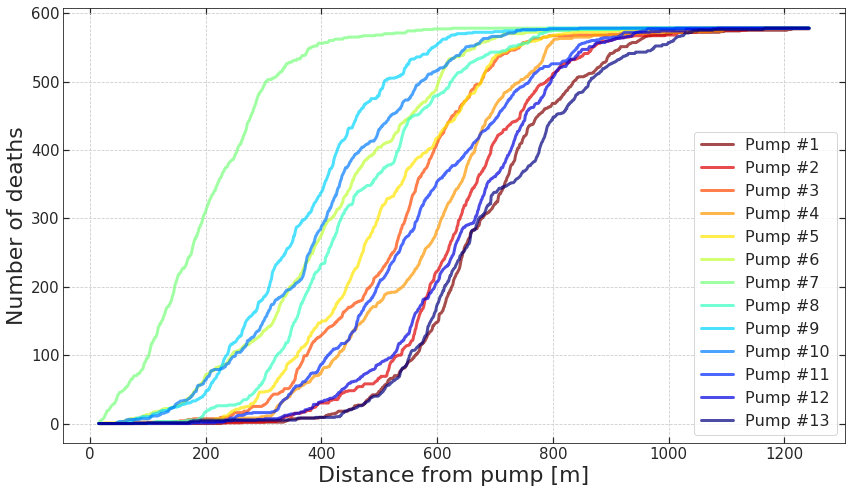

In [19]:
fig, axes = plt.subplots(figsize=(14,8))

axislabelsize = 22
axisticksize = 15
axislegendsize = 16

colors = pump_color(pumps.OBJECTID.values)
for idx, dists in dist_count.items():
    axes.plot(radius, dists, label='Pump #{0}'.format(idx),
              c=colors[idx-1], lw=3, alpha=0.7)

axes.set_xlabel('Distance from pump [m]', fontsize=axislabelsize)
axes.set_ylabel('Number of deaths', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

axes.legend(loc='lower right', fontsize=axislegendsize)

plt.show()

## Exercise 4

Put both the deaths and the pumps on a zoomable map that has a base layer from a tile server different from that of the default settings of your chosen method. Set the appropriate map center and zoom level. Use different markers for the deaths and the pumps datasets.

*Try folium in Python, or Leaflet in R or JS. Display the map here in the notebook.*

In [20]:
# Creating a Folium map object
# Here, we should use the original spherical coordinates!
# --------
# Center the map in a spherical coordinate system on the
# mean of the deaths' and pumps' location
lat_c = np.mean([np.mean(deaths.lat), np.mean(pumps.lat)])
long_c = np.mean([np.mean(deaths.long), np.mean(pumps.long)])

# Since we should use a different tile server, than the default 'OpenStreetMap',
# here I am using CartoDB's Positron map style, because this resembles mostly
# at the famous map of John Snow, inserted into the head of the notebook above
#
# In this variable name, JS stands for John Snow, and absolutely not for JavaScript
JS_map = folium.Map(location=[lat_c, long_c], zoom_start=16, tiles='CartoDB Positron')

# Mark deaths on map
for _, death in deaths.iterrows():
    marker = folium.Marker(location=[death.lat, death.long],
                           icon=folium.Icon(icon='ambulance', prefix='fa', color='black'),
                           popup='Death #{0}'.format(death.OBJECTID))
    marker.add_to(JS_map)

# Mark pumps on map
for _, pump in pumps.iterrows():
    marker = folium.Marker(location=[pump.lat, pump.long],
                           icon=folium.Icon(icon='glyphicon-tint', color='blue'),
                           popup='Pump #{0}'.format(pump.OBJECTID))
    marker.add_to(JS_map)

display(JS_map)

## Exercise 5

Calculate the Voronoi cells for the pumps, and count the number of deaths falling into each of the cells.  Create a bar chart of the number of deaths in each cell. Pinpoint the possible source of the infection.

*Store the Voronoi cells in a GeoDataFrame, then you can easily do a spatial join (e.g. testing whether a polygon in the Voronoi dataframe contains a point from the death dataframe).*

In [21]:
X_d = deaths.lat_proj_rs.values
Y_d = deaths.long_proj_rs.values

X_p = pumps.lat_proj_rs.values
Y_p = pumps.long_proj_rs.values

In [22]:
# Calculate spatial bounds of available data
min_x = np.min(np.concatenate((X_d, X_p)))
max_x = np.max(np.concatenate((X_d, X_p)))
min_y = np.min(np.concatenate((Y_d, Y_p)))
max_y = np.max(np.concatenate((Y_d, Y_p)))

# Calculate spatial size of data
size_x = max_x - min_x
size_y = max_y - min_y

In [23]:
# Calculate Voronoi cells using scipy's built-in function
vor = scipy.spatial.Voronoi(np.vstack([X_p, Y_p]).T)

/opt/conda/lib/python3.6/site-packages/scipy/spatial/_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


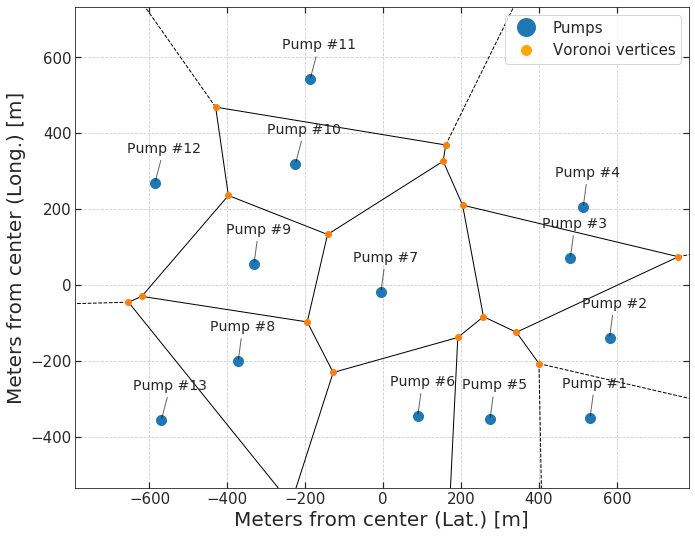

In [24]:
# Visualize the Voronoi cells
nrows = 1
ncols = 1
f_size = 11
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*f_size, nrows*f_size*size_y/size_x))

axislabelsize = 20
axisticksize = 15
axislegendsize = 15
s_radius = 20

# Scipy's built-in Voronoi cell visualizator
scipy.spatial.voronoi_plot_2d(vor, point_size=s_radius, ax=axes)

# Annotate pumps
for _, p in pumps.iterrows():
    axes.annotate('Pump #{0}'.format(p.OBJECTID),
                  xy=(p.lat_proj_rs, p.long_proj_rs), xycoords='data',
                  xytext=(-28, 30), textcoords='offset points', size='14',
                  arrowprops=dict(arrowstyle='-', color='black', alpha=0.6))

axes.set_xlabel('Meters from center (Lat.) [m]', fontsize=axislabelsize)
axes.set_ylabel('Meters from center (Long.) [m]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

# Set border limits
mult = 1.35
axes.set_xlim(mult*min_x, mult*max_x)
axes.set_ylim(mult*min_y, mult*max_y)

# Create figure legend
handles = [
    Line2D([0], [0], marker='o', color='w', label='Pumps', markerfacecolor='C0', markersize=s_radius),
    Line2D([0], [0], marker='o', color='w', label='Voronoi vertices', markerfacecolor='orange', markersize=12)
]
axes.legend(handles=handles, loc='upper right', fontsize=axislegendsize)

plt.show()

### Finding death count in Voronoi cells

Now we need to count all deaths in each Voronoi cells to create a meaningful visualization, which could be use then to pinpoint the source of the epidemic.

For an initial visualization, here I'll use the `cKDTree` method from the `scipy` library. The reason for this, that Voronoi cells of pumps are simply just the collection of points, which are nearest to a given pump. This interpretation makes the problem a lot easier, since it tell us that finding the number of deaths in a Voronoi cell is equivalent to the problem of finding the pumps nearest to the location of deaths and then counting all the neigbouring points of pumps thus obtained.

In [25]:
# Creating the KD-Tree for the pumps
voronoi_kdtree = scipy.spatial.cKDTree(np.vstack([X_p, Y_p]).T)

In [26]:
# Finding the closest pump neighbour of deaths
closest_pump_dist, closest_pump_regions = voronoi_kdtree.query(np.vstack([X_d, Y_d]).T)

In [27]:
# Choose distinct colors for the deaths in different
# Voronoi cells from a colormap
def choose_color(regions, cmap=cm.jet_r):
    region_idx = np.unique(regions)
    m = scipy.interpolate.interp1d([min(region_idx), max(region_idx)], [0,1])
    
    colors = {r: cmap(m(r)) for r in region_idx}
    
    colors_arr = []
    for d in regions:
        colors_arr.append(colors[d])
        
    return np.array(colors_arr)

/opt/conda/lib/python3.6/site-packages/scipy/spatial/_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


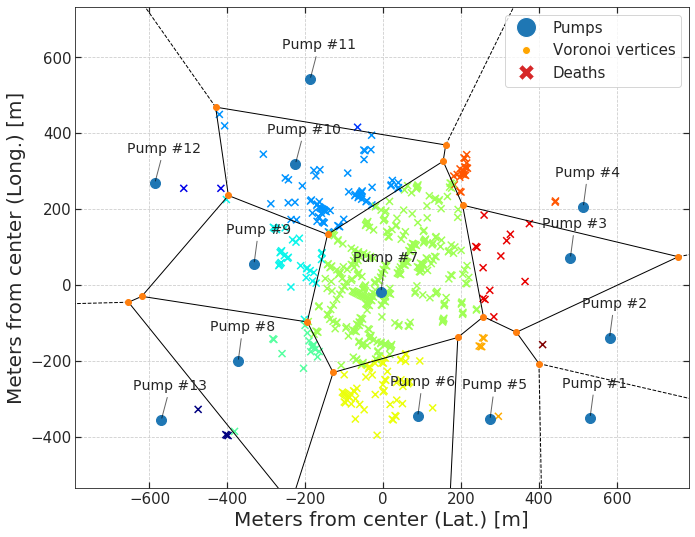

In [28]:
# Visualize the Voronoi cells
nrows = 1
ncols = 1
f_size = 11
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*f_size, nrows*f_size*size_y/size_x))

axislabelsize = 20
axisticksize = 15
axislegendsize = 15
s_p_radius = 20
s_d_radius = 7

axes.scatter(X_d, Y_d,
             c=choose_color(closest_pump_regions), marker='x', s=s_d_radius**2)

# Scipy's built-in Voronoi cell visualizator
scipy.spatial.voronoi_plot_2d(vor, point_size=s_p_radius, ax=axes)

# Annotate pumps
for _, p in pumps.iterrows():
    axes.annotate('Pump #{0}'.format(p.OBJECTID),
                  xy=(p.lat_proj_rs, p.long_proj_rs), xycoords='data',
                  xytext=(-28, 30), textcoords='offset points', size='14',
                  arrowprops=dict(arrowstyle='-', color='black', alpha=0.6))

axes.set_xlabel('Meters from center (Lat.) [m]', fontsize=axislabelsize)
axes.set_ylabel('Meters from center (Long.) [m]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

# Set border limits
mult = 1.35
axes.set_xlim(mult*min_x, mult*max_x)
axes.set_ylim(mult*min_y, mult*max_y)

# Create figure legend
handles = [
    Line2D([0], [0], marker='o', color='w', label='Pumps', markerfacecolor='C0', markersize=s_p_radius),
    Line2D([0], [0], marker='.', color='w', label='Voronoi vertices', markerfacecolor='orange', markersize=16),
    Line2D([0], [0], marker='X', color='w', label='Deaths', markerfacecolor='tab:red', markersize=16, lw=1)
]
axes.legend(handles=handles, loc='upper right', fontsize=axislegendsize)

plt.show()

Sadly the `cKDTree` method is unable to label regions correctly, and can't handle the case when there are Voronoi cells without test points. To create a usable dataset beyond a good-looking visualization, we have to use some point-in-polygon searching algorithm to identify and count deaths in the corresponding Voronoi cells.

Since some of the Voronoi cells are "unbounded/infinte polygons" - polygons with missing edges, we need to turn them first into "real/finite polygons". Using a function from GitHub at we can create these missing edges. (Source: https://gist.github.com/pv/8036995)

In [29]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [30]:
finite_regions, finite_vertices = voronoi_finite_polygons_2d(vor)

Using this function, we can recreate scipy's Voronoi cell visualizator.

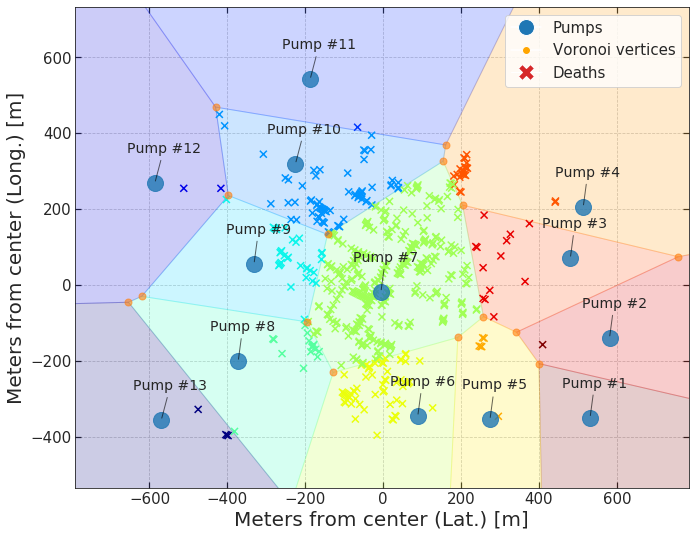

In [31]:
# Visualize the Voronoi cells
nrows = 1
ncols = 1
f_size = 11
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*f_size, nrows*f_size*size_y/size_x))

axislabelsize = 20
axisticksize = 15
axislegendsize = 15
s_v_radius = 7
s_p_radius = 16
s_d_radius = 7

# Color Voronoi cells
for idx, region in enumerate(finite_regions):
    polygon = finite_vertices[region]
    plt.fill(*zip(*polygon), color=colors[idx], alpha=0.2)

# Mark cell vertices
axes.scatter(finite_vertices[:,0], finite_vertices[:,1],
             c='tab:orange', s=s_v_radius**2, alpha=0.6, zorder=3)

# Mark pumps
axes.scatter(X_p, Y_p,
             c='C0', s=s_p_radius**2, alpha=0.8, zorder=3)

# Mark deaths
axes.scatter(X_d, Y_d,
             c=choose_color(closest_pump_regions), marker='x', s=s_d_radius**2, zorder=2)

# Annotate pumps
for _, p in pumps.iterrows():
    axes.annotate('Pump #{0}'.format(p.OBJECTID),
                  xy=(p.lat_proj_rs, p.long_proj_rs), xycoords='data',
                  xytext=(-28, 30), textcoords='offset points', size='14',
                  arrowprops=dict(arrowstyle='-', color='black', alpha=0.6))

axes.set_xlabel('Meters from center (Lat.) [m]', fontsize=axislabelsize)
axes.set_ylabel('Meters from center (Long.) [m]', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

# Set border limits
mult = 1.35
axes.set_xlim(mult*min_x, mult*max_x)
axes.set_ylim(mult*min_y, mult*max_y)

# Create figure legend
handles = [
    Line2D([0], [0], marker='o', color='w', label='Pumps', markerfacecolor='C0', markersize=s_p_radius),
    Line2D([0], [0], marker='.', color='w', label='Voronoi vertices', markerfacecolor='orange', markersize=16),
    Line2D([0], [0], marker='X', color='w', label='Deaths', markerfacecolor='tab:red', markersize=16, lw=1)
]
axes.legend(handles=handles, loc='upper right', fontsize=axislegendsize)

plt.show()

Now we can make a point-in-polygon searching algorithm and simply count the number of deaths in the finite polygons created above above.

In [32]:
# Initialize the counter for each pumps
deaths_near_pumps = {i+1: 0 for i in range(len(pumps))}

In [33]:
death_coords = np.vstack([X_d, Y_d]).T

# Loop through regions and count how many deaths are in them
for idx, r in enumerate(finite_regions):
    # Handle the current Voronoi cell as a shapely Polygon
    polygon = Polygon([finite_vertices[v] for v in r])
    for d in death_coords:
        # Handle the location of the current death as a shapely Point
        point = Point(d)
        
        # If the polygon cointains the point, increment the counter
        # of the current pump/cell
        if polygon.contains(point):
            deaths_near_pumps[idx+1] += 1

In [34]:
# death_near_pumps_arr
dnp_arr = np.array(list(deaths_near_pumps.items())).T

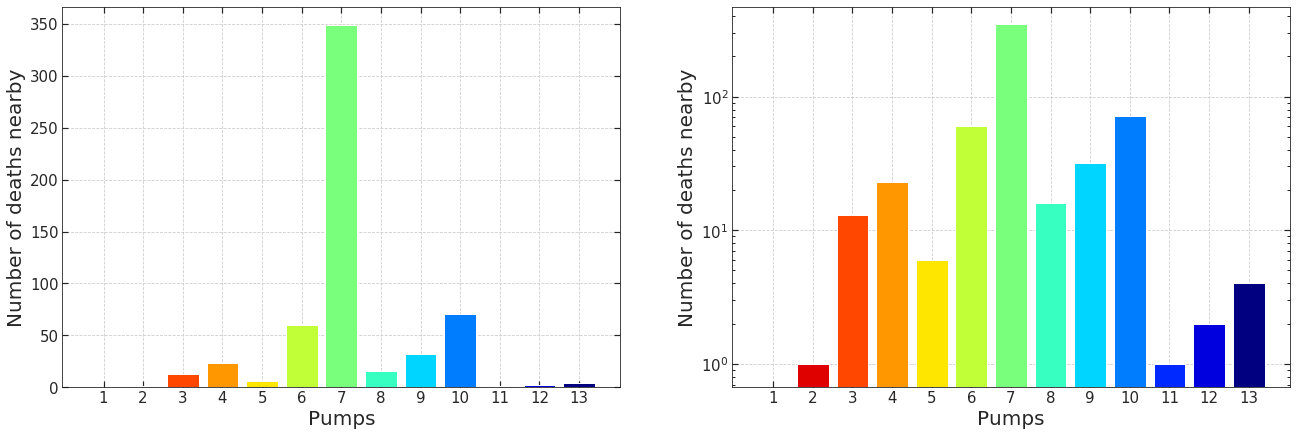

In [40]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*11, nrows*7))

axislabelsize = 20
axisticksize = 15

# One normal and one log scaled axis
axes[1].set_yscale('log')

for i in range(ncols):
    axes[i].bar(dnp_arr[0], dnp_arr[1], color=colors)

    plt.sca(axes[i])
    plt.xticks(dnp_arr[0], dnp_arr[0])

    axes[i].set_xlabel('Pumps', fontsize=axislabelsize)
    axes[i].set_ylabel('Number of deaths nearby', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)

plt.show()

## Exercise 6

Create a death density map using 2D Kernel Density Estimation. Display the density and its contours on the map along with the pumps. What is the density value at each of the pumps? Pinpoint the possible source of the infection.

*Use the projected Cartesian coordinate system for this exercise.* 

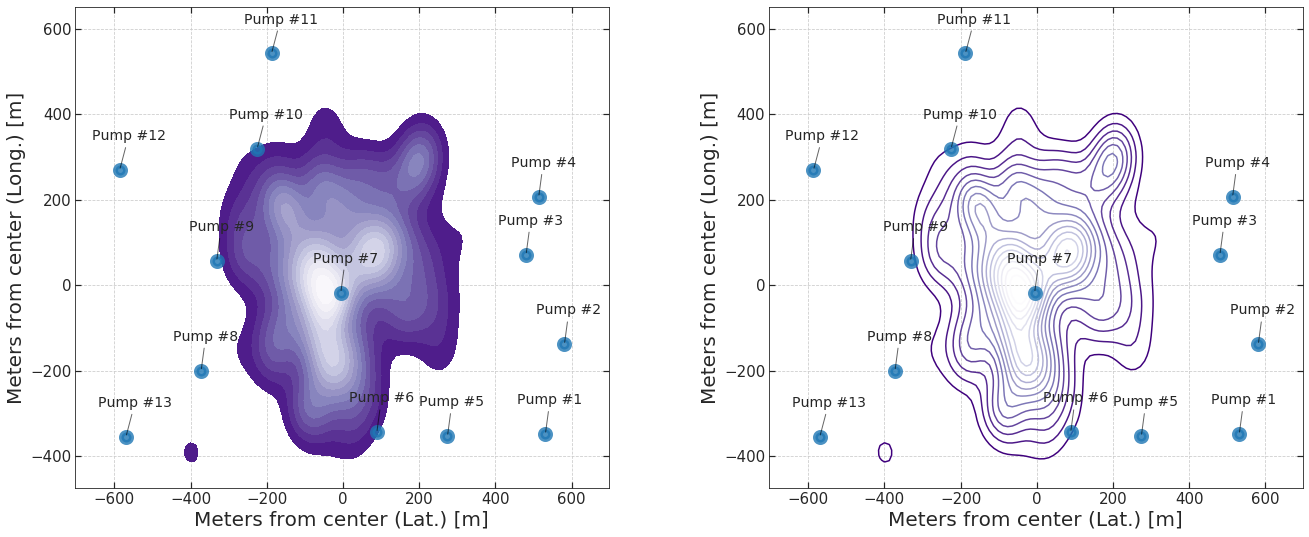

In [36]:
nrows = 1
ncols = 2
f_size = 11
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*f_size, nrows*f_size*size_y/size_x))
fig.subplots_adjust(wspace=0.3)

axislabelsize = 20
axisticksize = 15
s_radius= 10

# KDE plot of deaths
sns.kdeplot(X_d, Y_d, bw='scott',
            shade=True, shade_lowest=False,
            n_levels=15, cmap='Purples_r',
            ax=axes[0], zorder=1)

sns.kdeplot(X_d, Y_d,  bw='scott',
            n_levels=15, cmap='Purples_r',
            ax=axes[1], zorder=1)

for i in range(ncols):
    # Mark pump locations
    axes[i].scatter(X_p, Y_p, label='Pumps',
                    c='C0', marker='o', lw=5, s=s_radius**2, alpha=0.8)
    
    
    for _, p in pumps.iterrows():
        axes[i].annotate('Pump #{0}'.format(p.OBJECTID),
                         xy=(p.lat_proj_rs, p.long_proj_rs), xycoords='data',
                         xytext=(-28, 30), textcoords='offset points', size='14',
                         arrowprops=dict(arrowstyle='-', color='black', alpha=0.6))
    
    axes[i].set_xlabel('Meters from center (Lat.) [m]', fontsize=axislabelsize)
    axes[i].set_ylabel('Meters from center (Long.) [m]', fontsize=axislabelsize)
    axes[i].tick_params(axis='both', which='major', labelsize=axisticksize)
    
    axes[i].set_xlim(min_x*1.2, max_x*1.2)
    axes[i].set_ylim(min_y*1.2, max_y*1.2)
    
plt.show()

By the look of these density plots, Pump #7 is pretty suspicious... To further investigate, calculate the density values at the locations of the pumps.

In [37]:
XY_d = np.vstack([X_d, Y_d])
XY_p = np.vstack([X_p, Y_p])

# Gaussian KDE by choosing bandwith with Scott's method
kernel = scipy.stats.gaussian_kde(dataset=XY_d, bw_method='scott')

In [38]:
# Normalize probabilities for the next estimation
norm = np.sum(kernel(XY_p))

# Estimate probabilities of pumps being dangerous
for idx, xy in enumerate(XY_p.T):
    print(('Probability of poisoning of Pump #{0} is ' + b_on + 'P = {1:.4f} %' + b_off).format(idx+1,
                                                                                                kernel(xy)[0]/norm * 100))

Probability of poisoning of Pump #1 is P = 0.0002 %
Probability of poisoning of Pump #2 is P = 0.0032 %
Probability of poisoning of Pump #3 is P = 0.1566 %
Probability of poisoning of Pump #4 is P = 0.8099 %
Probability of poisoning of Pump #5 is P = 1.0981 %
Probability of poisoning of Pump #6 is P = 7.5381 %
Probability of poisoning of Pump #7 is P = 76.9573 %
Probability of poisoning of Pump #8 is P = 0.4867 %
Probability of poisoning of Pump #9 is P = 5.7234 %
Probability of poisoning of Pump #10 is P = 6.6584 %
Probability of poisoning of Pump #11 is P = 0.0053 %
Probability of poisoning of Pump #12 is P = 0.3673 %
Probability of poisoning of Pump #13 is P = 0.1955 %


According to this analysis, clearly Pump #7 is the most probable main source of the outbreak.

## Exercise 7

Create a GeoJSON object from the Voronoi cells, put the cells on the map, colored according to the number of deaths (like on a heatmap). Display the results in the notebook.

*[GeoJSON](http://geojson.org/) is a common format that is used in web applications. It is basically a simple key-value dictionary with a predefined structure for storing geographic information. Once loaded into Python, it behaves like a normal Python dictionary, thus creating or modifying it is quite straightforward. When reading or writing to a file, the `json` module is handy. The advice is to write a function that converts a list of coordinates from a polygon into a GeoJSON feature, then add it to your GeoJSON structure.*

## Exercise 8
(optional)
Download the street network of the area of the deaths from OpenStreetMap using its [map API](https://wiki.openstreetmap.org/wiki/API_v0.6#Retrieving_map_data_by_bounding_box:_GET_.2Fapi.2F0.6.2Fmap). Use street segments given back by the API as edges of a street graph. Develop a method based on the cholera dataset to classify these edges into three categories:
* existed at the time of John Snow
* did not exist at the time of John Snow
* cannot decide

*You'll get the id of each node and way that falls within a bounding box with the GET method of the map API. Use the ids to retrieve the shapes with the help of the ways API.*

*The results will be in XML format. Find a good [XML parser](https://docs.python.org/2/library/xml.etree.elementtree.html#module-xml.etree.ElementTree) to navigate the structures.*

## Exercise 9
(optional)

Plot the streets on the map along with the pumps and the deaths colored by the results of the classification.